In [1]:
import pandas as pd
import folium
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [17]:
# 데이터 프레임 생성 : df
df = pd.read_csv('2018_2021년 버스(지하철정보+출퇴근).csv', index_col=0)
df.head()

,정류장_ID,정류장_명칭,정류장_유형,정류장_번호,위도,경도,버스도착정보안내기_설치_여부,line,name,code,lat,lng,distance,출근,퇴근,총이동량
0,717104358,계수사거리(경유),가상정류장,0.0,126.817473,37.452473,미설치,01호선,역곡,1803.0,37.485178,126.811502,3.0,2224,384,2608
1,500000288,행사장입구,마을버스,25965.0,126.691556,37.321742,미설치,04호선,정왕,1761.0,37.351735,126.742989,5.0,1893,770,2663
2,500000287,행사장입구,마을버스,25095.0,126.691728,37.321942,미설치,04호선,정왕,1761.0,37.351735,126.742989,5.0,1491,281,1772
3,500000286,아남중전기,일반차로,25963.0,126.710485,37.319934,미설치,04호선,정왕,1761.0,37.351735,126.742989,4.0,2400,1424,3824
4,500000285,3Z,일반차로,25964.0,126.707130,37.320566,미설치,04호선,정왕,1761.0,37.351735,126.742989,4.0,173,466,639


In [18]:
df.describe()

,정류장_ID,정류장_번호,위도,경도,code,lat,lng,distance,출근,퇴근,총이동량
count,6.994200e+04,69922.000000,69939.000000,69939.000000,69939.000000,69939.000000,69939.000000,69939.000000,69942.000000,69942.000000,69942.000000
mean,2.026286e+08,25190.152012,127.006148,37.460201,1945.412088,37.475364,127.001029,6.737876,887.858068,1000.389937,1888.248005
std,5.203872e+07,21424.725500,0.745204,0.370326,1020.458487,0.230390,0.238783,72.827084,1611.185739,1730.220739,2851.209549
min,1.000000e+08,0.000000,0.000000,0.000000,150.000000,36.769502,126.476241,0.000000,0.000000,0.000000,0.000000
25%,1.670005e+08,2184.250000,126.818258,37.314649,1401.000000,37.316777,126.823249,0.415973,142.000000,136.000000,433.000000
50%,2.190011e+08,23700.500000,126.988362,37.493734,1750.000000,37.492904,127.030053,1.595443,452.000000,509.000000,1137.000000
75%,2.330013e+08,41282.750000,127.127404,37.636771,1958.000000,37.613292,127.104075,5.621082,1032.750000,1202.000000,2327.000000
max,7.171044e+08,98109.000000,129.442540,38.379051,4710.000000,37.948100,127.723792,13138.413037,47099.000000,38929.000000,82619.000000


### 출근 데이터순으로 정렬 및 정류정 유형 살펴보기

In [19]:
df.sort_values('출근', ascending=False, inplace=True)
df['정류장_유형'].unique()

array(['마을버스', '일반차로', '중앙차로', '가상정류장', '일반중앙차로', '가로변시간', '가로변전일', nan],
      dtype=object)

정류장 유형 중 가상정류장, 마을버스, nan 값은 제거

In [20]:
df = df[df['정류장_유형'] == ('일반차로' or '중앙차로' or '일반중앙차로' or '가로변시간' or '가로변전일')]
len(df)

37197

서울 내에 위치한 가장 가까운 지하철역간 거리 (distance)가 1분위수(0.415973) 이하 지역으로 축소

In [21]:
filter_75 = df['distance'] < df.describe()['distance']['50%']
df = df[filter_75]
len(df)

18597

boxplot으로 출근, 퇴근 분포 살펴보기

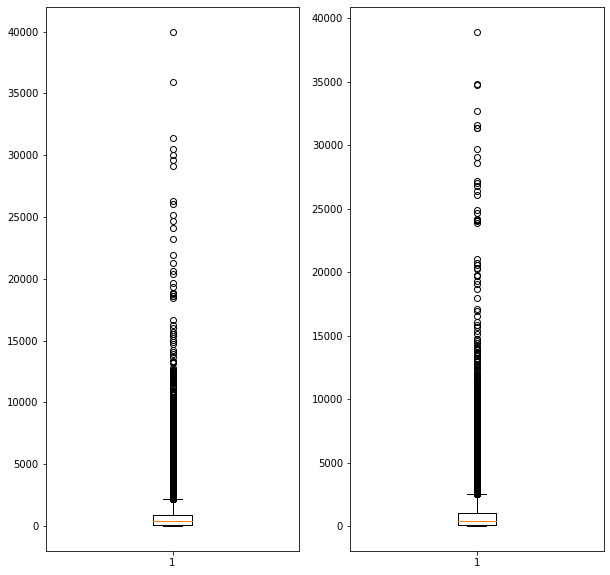

In [22]:
fig, ax = plt.subplots(1, 2, figsize= (10,10))
ax[0].boxplot(data=df, x='출근')
ax[1].boxplot(data=df, x='퇴근')
plt.show() 

3분위 이후에도 많은 이상치가 포진해있는 것을 확인할 수 있음. 상위의 값들을 살펴보기 위해 상위 n%의 값들만 남기기로 함.

In [23]:
# filter_0 = df['출근'] > df.describe()['출근']['75%']
filter_on = df['출근'] > df['출근'].quantile(q=0.9)
filter_off = df['퇴근'] > df['퇴근'].quantile(q=0.9)
df = df[filter_on]
df = df[filter_off]
len(df)

/var/folders/hr/y8znbyhd4058w4d5l14qqsv80000gn/T/ipykernel_2056/2622125712.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df[filter_off]


642

In [24]:
df.describe() # 출근 퇴근의 std (표준편차)가 커짐. 격차가 퍼져있는 모양.

,정류장_ID,정류장_번호,위도,경도,code,lat,lng,distance,출근,퇴근,총이동량
count,6.420000e+02,642.000000,642.000000,642.000000,642.000000,642.000000,642.000000,642.000000,642.000000,642.000000,642.000000
mean,1.927165e+08,26546.465732,126.927185,37.485695,2011.976636,37.485847,126.927451,0.453663,4961.143302,5599.931464,10561.074766
std,4.379265e+07,23141.775263,0.199435,0.143205,994.019760,0.142660,0.198390,0.385619,4744.281650,5331.721375,8952.674040
min,1.000000e+08,0.000000,126.482846,37.004282,150.000000,36.990726,126.493790,0.000000,1850.000000,2111.000000,3976.000000
25%,1.650003e+08,283.500000,126.742857,37.418157,1352.750000,37.417804,126.748831,0.000000,2368.250000,2667.000000,5699.250000
50%,2.060003e+08,25514.500000,126.927121,37.479575,1810.000000,37.482230,126.929141,0.452053,3249.000000,3617.000000,7527.500000
75%,2.220002e+08,41022.000000,127.086737,37.559681,2821.000000,37.558639,127.083894,0.845624,5380.000000,5937.000000,11679.750000
max,2.771024e+08,92040.000000,127.599371,37.911153,4701.000000,37.913702,127.594647,1.026574,39979.000000,38929.000000,70641.000000


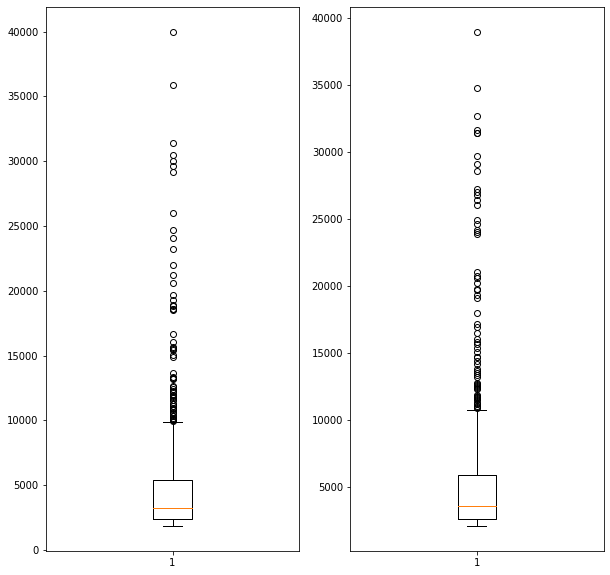

In [25]:
fig, ax = plt.subplots(1, 2, figsize= (10,10))
ax[0].boxplot(data=df, x='출근')
ax[1].boxplot(data=df, x='퇴근')
plt.show() 

In [26]:
# df.describe()['출근']['25%']
# df.describe()['출근']['50%']
# df.describe()['출근']['75%']
# df.describe()['출근']['max']

In [27]:
my_map_on = folium.Map(location=[37.5502, 126.982], zoom_start=10)

for idx, rows in df.iterrows():
    try:
        if rows['출근'] < df.describe()['출근']['25%'] :
            folium.Marker(location=[rows['경도'], rows['위도']],
                            icon=folium.Icon(
                                color='red',
                                icon_color='white',
                                icon='glyphicon glyphicon-cloud',
                                prefix='glyphicon'),
                            popup=rows['정류장_명칭']).add_to(my_map_on)
                            
        elif rows['출근'] < df.describe()['출근']['50%'] :
            folium.Marker(location=[rows['경도'], rows['위도']],
                            icon=folium.Icon(
                                color='orange',
                                icon_color='white',
                                icon='glyphicon glyphicon-cloud',
                                prefix='glyphicon'),
                            popup=rows['정류장_명칭']).add_to(my_map_on)
                            
        elif rows['출근'] < df.describe()['출근']['75%'] :
            folium.Marker(location=[rows['경도'], rows['위도']],
                            icon=folium.Icon(
                                color='yellow',
                                icon_color='white',
                                icon='glyphicon glyphicon-cloud',
                                prefix='glyphicon'),
                            popup=rows['정류장_명칭']).add_to(my_map_on)
                            
        else :
            folium.Marker(location=[rows['경도'], rows['위도']],
                            icon=folium.Icon(
                                color='green',
                                icon_color='white',
                                icon='glyphicon glyphicon-cloud',
                                prefix='glyphicon'),
                            popup=rows['정류장_명칭']).add_to(my_map_on)
                            
    except:
        pass

/var/folders/hr/y8znbyhd4058w4d5l14qqsv80000gn/T/ipykernel_2056/2876964892.py:25: UserWarning: color argument of Icon should be one of: {'green', 'gray', 'red', 'darkblue', 'darkpurple', 'lightgray', 'pink', 'lightblue', 'white', 'cadetblue', 'purple', 'darkgreen', 'lightred', 'orange', 'lightgreen', 'darkred', 'blue', 'beige', 'black'}.
  icon=folium.Icon(
/var/folders/hr/y8znbyhd4058w4d5l14qqsv80000gn/T/ipykernel_2056/2876964892.py:25: UserWarning: color argument of Icon should be one of: {'green', 'gray', 'red', 'darkblue', 'darkpurple', 'lightgray', 'pink', 'lightblue', 'white', 'cadetblue', 'purple', 'darkgreen', 'lightred', 'orange', 'lightgreen', 'darkred', 'blue', 'beige', 'black'}.
  icon=folium.Icon(
/var/folders/hr/y8znbyhd4058w4d5l14qqsv80000gn/T/ipykernel_2056/2876964892.py:25: UserWarning: color argument of Icon should be one of: {'green', 'gray', 'red', 'darkblue', 'darkpurple', 'lightgray', 'pink', 'lightblue', 'white', 'cadetblue', 'purple', 'darkgreen', 'lightred', 'o

In [28]:
# my_map_on.save('bus_folium.html')

In [29]:
my_map_on

In [30]:
my_map_off = folium.Map(location=[37.5502, 126.982], zoom_start=10)

for idx, rows in df.iterrows():
    try:
        if rows['퇴근'] < df.describe()['퇴근']['25%'] :
            folium.Marker(location=[rows['경도'], rows['위도']],
                            icon=folium.Icon(
                                color='red',
                                icon_color='white',
                                icon='glyphicon glyphicon-cloud',
                                prefix='glyphicon'),
                            popup=rows['정류장_명칭']).add_to(my_map_off)
                            
        elif rows['퇴근'] < df.describe()['퇴근']['50%'] :
            folium.Marker(location=[rows['경도'], rows['위도']],
                            icon=folium.Icon(
                                color='orange',
                                icon_color='white',
                                icon='glyphicon glyphicon-cloud',
                                prefix='glyphicon'),
                            popup=rows['정류장_명칭']).add_to(my_map_off)
                            
        elif rows['퇴근'] < df.describe()['퇴근']['75%'] :
            folium.Marker(location=[rows['경도'], rows['위도']],
                            icon=folium.Icon(
                                color='yellow',
                                icon_color='white',
                                icon='glyphicon glyphicon-cloud',
                                prefix='glyphicon'),
                            popup=rows['정류장_명칭']).add_to(my_map_off)
                            
        else :
            folium.Marker(location=[rows['경도'], rows['위도']],
                            icon=folium.Icon(
                                color='green',
                                icon_color='white',
                                icon='glyphicon glyphicon-cloud',
                                prefix='glyphicon'),
                            popup=rows['정류장_명칭']).add_to(my_map_off)
                            
    except:
        pass

/var/folders/hr/y8znbyhd4058w4d5l14qqsv80000gn/T/ipykernel_2056/526501361.py:25: UserWarning: color argument of Icon should be one of: {'green', 'gray', 'red', 'darkblue', 'darkpurple', 'lightgray', 'pink', 'lightblue', 'white', 'cadetblue', 'purple', 'darkgreen', 'lightred', 'orange', 'lightgreen', 'darkred', 'blue', 'beige', 'black'}.
  icon=folium.Icon(
/var/folders/hr/y8znbyhd4058w4d5l14qqsv80000gn/T/ipykernel_2056/526501361.py:25: UserWarning: color argument of Icon should be one of: {'green', 'gray', 'red', 'darkblue', 'darkpurple', 'lightgray', 'pink', 'lightblue', 'white', 'cadetblue', 'purple', 'darkgreen', 'lightred', 'orange', 'lightgreen', 'darkred', 'blue', 'beige', 'black'}.
  icon=folium.Icon(
/var/folders/hr/y8znbyhd4058w4d5l14qqsv80000gn/T/ipykernel_2056/526501361.py:25: UserWarning: color argument of Icon should be one of: {'green', 'gray', 'red', 'darkblue', 'darkpurple', 'lightgray', 'pink', 'lightblue', 'white', 'cadetblue', 'purple', 'darkgreen', 'lightred', 'oran

In [31]:
my_map_off

버스로는 실질적인 출퇴근 지역을 파악하기 어려움. 그러나 승,하차가 많은 지역들이 대체적으로 몰려있는 것을 보아 그 방향으로 이동하며 환승하여 이동하거나 그 위치에 회사가 위치해 있을 것이라고 예측할 수 있음
  
따라서 본 버스의 출퇴근 자료는 이동량의 추이를 바탕으로 코로나 전 후를 살펴보는 데에 적합한 자료로 판단됨.